In [5]:
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import pennylane as pl
from torch import nn
from pennylane import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from torch.utils.data import DataLoader, TensorDataset

In [8]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.quantum_models as qm

# 1-Small Scale model testing
We apply the Fourier_best_approx to approximate a sin function.
We first determine the coeffs

In [9]:
import numpy as np
import torch
from itertools import product

# Fourier best approximation function
def fourier_best_approx(W, x, y):
    W = W.t()
    z = x.matmul(W)
    A_cos = z.cos()
    A_sin = z.sin()
    A = torch.cat((A_cos, A_sin), 1)
    coeffs = torch.linalg.lstsq(A, y, driver='gelsd').solution.squeeze(-1)
    return coeffs

# Create a dataset
num_samples = 1000
x_values = np.linspace(0, 2 * np.pi, num_samples)
y_values = np.sin(x_values)

# Convert the data to PyTorch tensors
X_tensor = torch.tensor(x_values, dtype=torch.float64).view(-1, 1) # I have changed utils W to 32 !!
y_tensor = torch.tensor(y_values, dtype=torch.float64).view(-1, 1)

# Generate frequencies using the freq_generator function
max_freq = 2  # You can adjust max_freq as needed
dim = 1  # Since we are working with a 1-dimensional sine function
W = utils.freq_generator(max_freq, dim, mode="half")
# Use the fourier_best_approx function to compute the Fourier coefficients
coeffs = fourier_best_approx(W, X_tensor, y_tensor)

# Output the coefficients
print(coeffs)


tensor([-7.9471e-18, -6.5546e-18, -1.0604e-17,  1.0000e+00, -2.7394e-17,
         0.0000e+00], dtype=torch.float64)


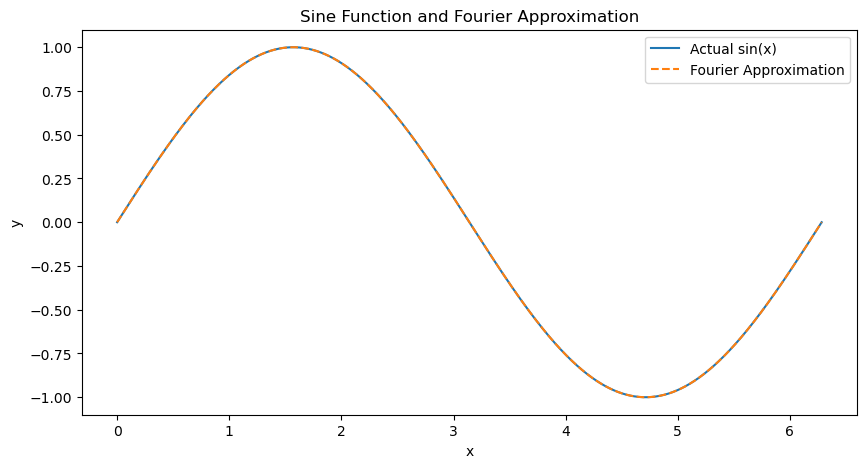

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Assuming 'coeffs' is the output from the previous function and 'W' is the frequency tensor

# Reconstruct the Fourier series approximation over the interval [0, 2π]
x_vals = torch.linspace(0, 2 * np.pi, 1000, dtype=torch.float64).unsqueeze(1)  # Ensure x_vals is also double
W_recon = W.t()  # This should already be a Double tensor if W was created as Double
z_recon = x_vals.matmul(W_recon)
A_cos_recon = z_recon.cos()
A_sin_recon = z_recon.sin()
A_recon = torch.cat((A_cos_recon, A_sin_recon), 1)

# Approximate y values using the Fourier coefficients
y_approx = A_recon.matmul(coeffs.unsqueeze(1)).squeeze(1)

# Plot the actual sine function and the Fourier approximation
plt.figure(figsize=(10, 5))
plt.plot(x_vals.numpy(), torch.sin(x_vals).numpy(), label='Actual sin(x)')
plt.plot(x_vals.numpy(), y_approx.numpy(), label='Fourier Approximation', linestyle='--')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Function and Fourier Approximation')
plt.show()


# 2-Inversion on California housing dataset
- Max freq = 1
- Mode = half 
- Precision 0 float 32
- Data rescaled to [-pi/2 , pi/2]

In [14]:
# Fetch data
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split dataset into training + validation and testing
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Further split into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=2)

# Calculate scaling parameters from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the datasets
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))

# Targets do not need scaling for regression tasks but ensure they are tensors
y_train_tensor = y_train.unsqueeze(1)
y_val_tensor = y_val.unsqueeze(1)
y_test_tensor = y_test.unsqueeze(1)

# Generate frequencies
max_freq = 1  
dim = X_train.shape[1]
W = utils.freq_generator(max_freq, dim, mode="half").float()

First we calculate the Fourier Series coefficients.

In [18]:
coeffs = fourier_best_approx(W, X_train_scaled, y_train_tensor )
print(coeffs)

tensor([ 0.0486,  0.0766,  0.0264,  ..., -0.0100, -0.0081,  0.0000])


Now we calculate the loss MSE on the three sets 

In [31]:
from torchmetrics import MeanSquaredError
mse = MeanSquaredError()

def loss(W, C, X, y):
    z = X.matmul(W.t())
    A_cos = z.cos()
    A_sin = z.sin()
    A = torch.cat((A_cos, A_sin), 1)
    y_pred = A.matmul(C.t())
    y_pred = y_pred.squeeze()  # Adjust the shape of y_pred
    return mse(y_pred, y.squeeze())  # Ensure y is also squeezed

# Calculate losses
train_loss = loss(W, coeffs, X_train_scaled, y_train_tensor)
val_loss = loss(W, coeffs, X_val_scaled, y_val_tensor)
test_loss = loss(W, coeffs, X_test_scaled, y_test_tensor)

print(f"Train Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")
print(f"Test Loss: {test_loss}")


Train Loss: 0.38332393765449524
Validation Loss: 0.44773727655410767
Test Loss: 1.2294524908065796


Memory allocation problem to be solved.

In [36]:
# Generate frequencies
max_freq = 2  
dim = X_train.shape[1]
W = utils.freq_generator(max_freq, dim, mode="half").float()

In [37]:
coeffs2 = fourier_best_approx(W, X_train_scaled, y_train_tensor )
print(coeffs2)

RuntimeError: [enforce fail at alloc_cpu.cpp:83] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 9675024768 bytes. Error code 12 (Cannot allocate memory)